In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df_train = pd.read_csv('train.csv')
df_resources = pd.read_csv('resources.csv')
train_resource = pd.merge(df_train, df_resources, on="id", how='left')
df_train[df_train.teacher_prefix.isnull()]
train_resource[train_resource.description.isnull()].head()
t2 = train_resource.pivot_table(index = ['id', 'description'],
                                values='quantity', 
                                aggfunc=np.sum)
t2.reset_index(inplace=True)
train_resource = pd.merge(train_resource,
                          t2, 
                          on=['id', 'description'], 
                          how='right',
                          suffixes=('_Orig', '_True'))

train_resource = train_resource.drop_duplicates()
train_resource = train_resource.drop('quantity_Orig', axis=1)
train_resource = train_resource.rename(columns={'quantity_True': 'True_Quantity'})
train_resource['Total_Cost'] = train_resource.price * train_resource.True_Quantity
Total_cost = train_resource.pivot_table(values=['Total_Cost','True_Quantity'],
                                        index='id',
                                        aggfunc={'Total_Cost' : np.sum, 'True_Quantity' : np.sum})
Total_cost.reset_index(level=0, inplace = True)

df_train = df_train.merge(Total_cost, on='id', how='left')
df_train['Average_item_cost'] = df_train.Total_Cost  / df_train.True_Quantity

df = df_train
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182080 entries, 0 to 182079
Data columns (total 19 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [5]:
#https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
from __future__ import print_function

# Remove attributes that arent useful
if 'project_essay_3' in df:
    del df['project_essay_3']
if 'project_essay_4' in df:    
    del df['project_essay_4']

# drop rows that still had missing values after grouped imputation
df.dropna(inplace=True)

# take natural log of right skewed attributes
df['teacher_number_of_previously_posted_projects']=np.log1p(df.teacher_number_of_previously_posted_projects)
df['Total_Cost']=np.log1p(df.Total_Cost)
df['True_Quantity']=np.log1p(df.True_Quantity)
df['Average_item_cost']=np.log1p(df.Average_item_cost)

# Keep these attributes
df = df[['teacher_number_of_previously_posted_projects','Total_Cost','True_Quantity','Average_item_cost','project_is_approved']]
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182073 entries, 0 to 182079
Data columns (total 5 columns):
teacher_number_of_previously_posted_projects    182073 non-null float64
Total_Cost                                      182073 non-null float64
True_Quantity                                   182073 non-null float64
Average_item_cost                               182073 non-null float64
project_is_approved                             182073 non-null int64
dtypes: float64(4), int64(1)
memory usage: 8.3 MB


In [7]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'project_is_approved' in df:
    y = df['project_is_approved'].values # get the labels we want
    del df['project_is_approved'] # get rid of the class label
    X = df.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [8]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l1', C=1.0, class_weight='balanced') # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.533983248661266
confusion matrix
 [[ 3728  1804]
 [15166 15717]]
====Iteration 1  ====
accuracy 0.5229987642455032
confusion matrix
 [[ 3719  1806]
 [15564 15326]]
====Iteration 2  ====
accuracy 0.5288205409858575
confusion matrix
 [[ 3804  1746]
 [15412 15453]]


In [9]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l1', C=0.05, class_weight='balanced') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.5290676918852122
[[ 3801  1749]
 [15400 15465]]
Total_Cost has weight of -1.3404691312287877
teacher_number_of_previously_posted_projects has weight of 0.22943292910118443
True_Quantity has weight of 1.7557369576254753
Average_item_cost has weight of 2.272152231557523


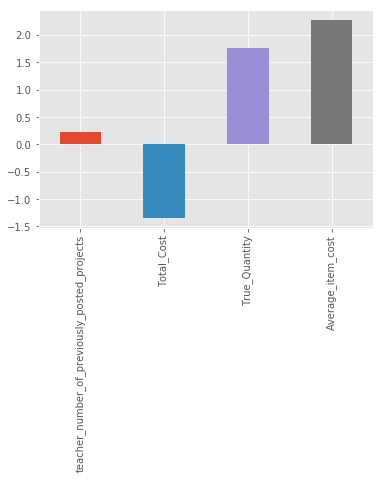

In [10]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')
plt.show()